# Natural Language Translation

In this lesson we will learn the basics of Natural Language Translation using Python libraries.

<img src='figures/nltk.jpg' width=350>

# Introduction
This Kernel is for all who think they need to review their knowledge on NLTK.

In [131]:
# Let's make sure the libraries are installed
#!pip3 install spacy && python3 -m spacy download en
#!pip install seaborn
#!pip install pandas
#!pip install numpy
#!pip install matplotlib
#!pip install sklearn
#!pip install scipy

# Now import the libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import warnings
import sklearn
import gensim
import scipy
import numpy
import json
import nltk
import sys
import csv
import os

import warnings
warnings.filterwarnings('ignore')

In [132]:
print('matplotlib: {}'.format(matplotlib.__version__))
print('scipy: {}'.format(scipy.__version__))
print('seaborn: {}'.format(sns.__version__))
print('pandas: {}'.format(pd.__version__))
print('numpy: {}'.format(np.__version__))
print('Python: {}'.format(sys.version))

matplotlib: 3.0.3
scipy: 1.2.1
seaborn: 0.9.0
pandas: 0.24.2
numpy: 1.16.2
Python: 3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]


## Setup

A few tiny adjustments for better **code readability**

In [133]:
sns.set(style='white', context='notebook', palette='deep')
warnings.filterwarnings('ignore')
sns.set_style('white')
%matplotlib inline

## Data set

In [134]:
print(os.listdir("data/"))

['kaggle_sample_submission_stage_1.csv', 'kaggle_test_stage_1.tsv', 'surnames.csv', 'titanic.csv']


In [135]:
gendered_pronoun_df = pd.read_csv('data/kaggle_test_stage_1.tsv', delimiter='\t')

In [136]:
submission = pd.read_csv('data/kaggle_sample_submission_stage_1.csv')

In [137]:
gendered_pronoun_df.shape

(2000, 9)

In [138]:
submission.shape

(2000, 4)

## Gendered Pronoun Data set Analysis
<img src='figures/PronounResolution.png' width=400>

Pronoun resolution is part of coreference resolution, the task of pairing an expression to its referring entity. This is an important task for natural language understanding, and the resolution of ambiguous pronouns is a longstanding challenge.


### Problem Feature
Here, you must identify the target of a pronoun within a text passage. The source text is taken from Wikipedia articles. You are provided with the pronoun and two candidate names to which the pronoun could refer. You must create an algorithm capable of deciding whether the pronoun refers to name A, name B, or neither.

In [139]:
gendered_pronoun_df.head()

,ID,Text,Pronoun,Pronoun-offset,A,A-offset,B,B-offset,URL
0,development-1,Zoe Telford -- played the police officer girlf...,her,274,Cheryl Cassidy,191,Pauline,207,http://en.wikipedia.org/wiki/List_of_Teachers_...
1,development-2,"He grew up in Evanston, Illinois the second ol...",His,284,MacKenzie,228,Bernard Leach,251,http://en.wikipedia.org/wiki/Warren_MacKenzie
2,development-3,"He had been reelected to Congress, but resigne...",his,265,Angeloz,173,De la Sota,246,http://en.wikipedia.org/wiki/Jos%C3%A9_Manuel_...
3,development-4,The current members of Crime have also perform...,his,321,Hell,174,Henry Rosenthal,336,http://en.wikipedia.org/wiki/Crime_(band)
4,development-5,Her Santa Fe Opera debut in 2005 was as Nuria ...,She,437,Kitty Oppenheimer,219,Rivera,294,http://en.wikipedia.org/wiki/Jessica_Rivera


### Variables

1. ID - Unique identifier for an example (Matches to Id in output file format)
1. Text - Text containing the ambiguous pronoun and two candidate names (about a paragraph in length)
1. Pronoun - The target pronoun (text)
1. Pronoun-offset The character offset of Pronoun in Text
1. A - The first name candidate (text)
1. A-offset - The character offset of name A in Text
1. B - The second name candidate
1. B-offset - The character offset of name B in Text
1. URL - The URL of the source Wikipedia page for the example

In [140]:
print(gendered_pronoun_df.Text.head())

0    Zoe Telford -- played the police officer girlf...
1    He grew up in Evanston, Illinois the second ol...
2    He had been reelected to Congress, but resigne...
3    The current members of Crime have also perform...
4    Her Santa Fe Opera debut in 2005 was as Nuria ...
Name: Text, dtype: object


## Evaluation
Submissions are evaluated using the multi-class logarithmic loss. Each pronoun has been labeled with whether it refers to A, B, or NEITHER. For each pronoun, you must submit a set of predicted probabilities (one for each class). The formula is :
<img src='figures/logloss.png' width=300>

In [141]:
print("Shape of train set : ",gendered_pronoun_df.shape)

Shape of train set :  (2000, 9)


In [142]:
gendered_pronoun_df.columns

Index(['ID', 'Text', 'Pronoun', 'Pronoun-offset', 'A', 'A-offset', 'B',
       'B-offset', 'URL'],
      dtype='object')

In [143]:
print(gendered_pronoun_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
ID                2000 non-null object
Text              2000 non-null object
Pronoun           2000 non-null object
Pronoun-offset    2000 non-null int64
A                 2000 non-null object
A-offset          2000 non-null int64
B                 2000 non-null object
B-offset          2000 non-null int64
URL               2000 non-null object
dtypes: int64(3), object(6)
memory usage: 140.7+ KB
None


In [144]:
gendered_pronoun_df.isna().sum()

ID                0
Text              0
Pronoun           0
Pronoun-offset    0
A                 0
A-offset          0
B                 0
B-offset          0
URL               0
dtype: int64

## Some new features
In this section, we extract a few new statistical features from the text field

### Number of words in the text

In [145]:
gendered_pronoun_df["num_words"] = gendered_pronoun_df["Text"].apply(lambda x: len(str(x).split()))

In [146]:
print('maximum of num_words in data_df',gendered_pronoun_df["num_words"].max())
print('min of num_words in data_df',gendered_pronoun_df["num_words"].min())

maximum of num_words in data_df 204
min of num_words in data_df 16


### Number of unique words in the text

In [147]:
gendered_pronoun_df["num_unique_words"] = gendered_pronoun_df["Text"].apply(lambda x: len(set(str(x).split())))
print('maximum of num_unique_words in train',gendered_pronoun_df["num_unique_words"].max())
print('mean of num_unique_words in data_df',gendered_pronoun_df["num_unique_words"].mean())

maximum of num_unique_words in train 136
mean of num_unique_words in data_df 56.4005


### Number of characters in the text

In [148]:
gendered_pronoun_df["num_chars"] = gendered_pronoun_df["Text"].apply(lambda x: len(str(x)))
print('maximum of num_chars in data_df',gendered_pronoun_df["num_chars"].max())

maximum of num_chars in data_df 1270


### Number of stopwords in the text

In [149]:
from nltk.corpus import stopwords
eng_stopwords = set(stopwords.words("english"))

In [150]:
gendered_pronoun_df["num_stopwords"] = gendered_pronoun_df["Text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

print('maximum of num_stopwords in data_df',gendered_pronoun_df["num_stopwords"].max())

maximum of num_stopwords in data_df 88


### Number of punctuations in the text


In [151]:
import string
gendered_pronoun_df["num_punctuations"] =gendered_pronoun_df['Text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
print('maximum of num_punctuations in data_df',gendered_pronoun_df["num_punctuations"].max())

maximum of num_punctuations in data_df 93


### Number of title case words in the text

In [152]:
gendered_pronoun_df["num_words_upper"] = gendered_pronoun_df["Text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
print('maximum of num_words_upper in data_df',gendered_pronoun_df["num_words_upper"].max())

maximum of num_words_upper in data_df 11


In [153]:
print(gendered_pronoun_df.columns)
gendered_pronoun_df.head(1)

Index(['ID', 'Text', 'Pronoun', 'Pronoun-offset', 'A', 'A-offset', 'B',
       'B-offset', 'URL', 'num_words', 'num_unique_words', 'num_chars',
       'num_stopwords', 'num_punctuations', 'num_words_upper'],
      dtype='object')


,ID,Text,Pronoun,Pronoun-offset,A,A-offset,B,B-offset,URL,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper
0,development-1,Zoe Telford -- played the police officer girlf...,her,274,Cheryl Cassidy,191,Pauline,207,http://en.wikipedia.org/wiki/List_of_Teachers_...,74,61,426,29,14,0


In [154]:
pronoun=gendered_pronoun_df["Pronoun"]

In [155]:
np.unique(pronoun)

array(['He', 'Her', 'His', 'She', 'he', 'her', 'him', 'his', 'she'],
      dtype=object)

In [156]:
gendered_pronoun_df["Pronoun_binary"] = gendered_pronoun_df["Pronoun"]

In [157]:
gendered_pronoun_df["Pronoun_binary"]=gendered_pronoun_df["Pronoun_binary"].str.replace('He','0')
gendered_pronoun_df["Pronoun_binary"]=gendered_pronoun_df["Pronoun_binary"].str.replace('he','0')
gendered_pronoun_df["Pronoun_binary"]=gendered_pronoun_df["Pronoun_binary"].str.replace('she','1')
gendered_pronoun_df["Pronoun_binary"]=gendered_pronoun_df["Pronoun_binary"].str.replace('She','1')
gendered_pronoun_df["Pronoun_binary"]=gendered_pronoun_df["Pronoun_binary"].str.replace('His','2')
gendered_pronoun_df["Pronoun_binary"]=gendered_pronoun_df["Pronoun_binary"].str.replace('his','2')
gendered_pronoun_df["Pronoun_binary"]=gendered_pronoun_df["Pronoun_binary"].str.replace('him','3')
gendered_pronoun_df["Pronoun_binary"]=gendered_pronoun_df["Pronoun_binary"].str.replace('her','4')
gendered_pronoun_df["Pronoun_binary"]=gendered_pronoun_df["Pronoun_binary"].str.replace('Her','4')

## Visualization

### WordCloud

In [158]:
from wordcloud import WordCloud as wc
from nltk.corpus import stopwords
def generate_wordcloud(text): 
    wordcloud = wc(relative_scaling = 1.0,stopwords = eng_stopwords).generate(text)
    fig,ax = plt.subplots(1,1,figsize=(10,10))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    ax.margins(x=0, y=0)
    plt.show()

In [159]:
from nltk.corpus import stopwords
eng_stopwords = set(stopwords.words("english"))

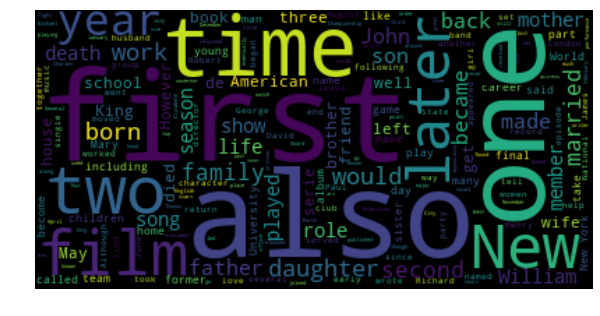

In [160]:
text =" ".join(gendered_pronoun_df.Text)
generate_wordcloud(text)

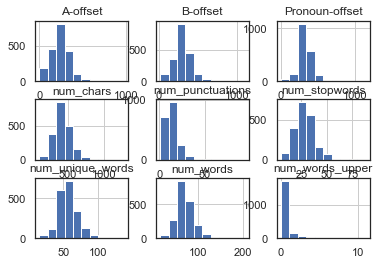

In [161]:
gendered_pronoun_df.hist();

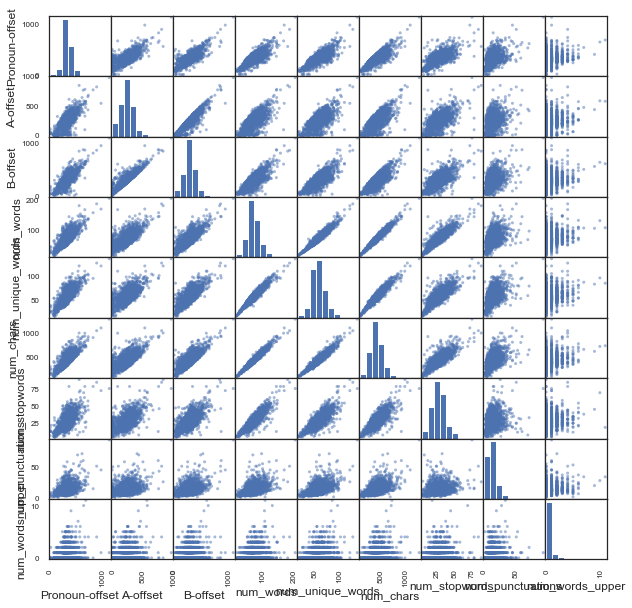

<Figure size 432x288 with 0 Axes>

In [162]:
pd.plotting.scatter_matrix(gendered_pronoun_df,figsize=(10,10))
plt.figure();

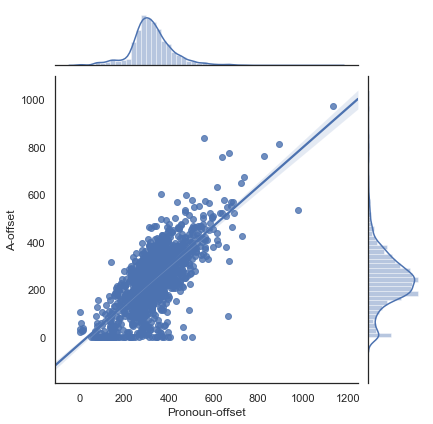

In [163]:
sns.jointplot(x='Pronoun-offset',y='A-offset' ,data=gendered_pronoun_df, kind='reg')

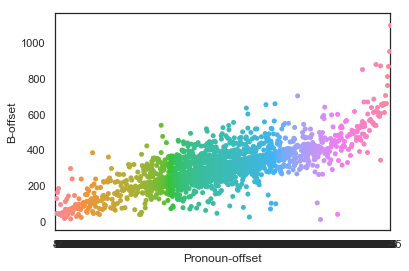

In [164]:
sns.swarmplot(x='Pronoun-offset',y='B-offset',data=gendered_pronoun_df);

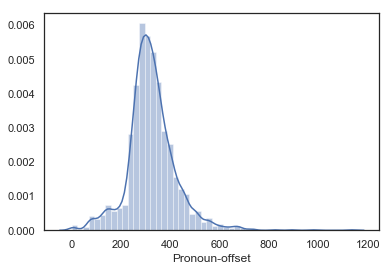

In [165]:
sns.distplot(gendered_pronoun_df["Pronoun-offset"])

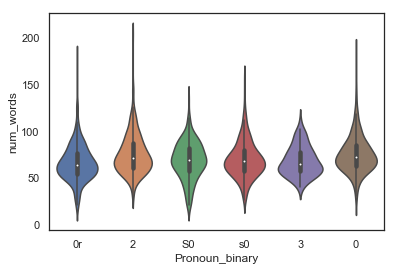

In [166]:
sns.violinplot(data=gendered_pronoun_df,x="Pronoun_binary", y="num_words")

# NLTK
The Natural Language Toolkit (NLTK) is one of the leading platforms for working with human language data and Python, the module NLTK is used for natural language processing. NLTK is literally an acronym for Natural Language Toolkit. with it you can tokenizing words and sentences.
NLTK is a library of Python that can mine (scrap and upload data) and analyse very large amounts of textual data using computational methods.

<img src='figures/nltk.jpg' width=300>

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')

#nltk.data.path.append('data/nltk_data/punkt/')
#nltk.download('punkt', download_dir='data/nltk_data/punkt')
#with open("data/nltk_data/punkt/english", "rb") as resource:
#    sent_tokenizer = pickle.load(resource)

In [168]:
gendered_pronoun_df.Text[0]

"Zoe Telford -- played the police officer girlfriend of Simon, Maggie. Dumped by Simon in the final episode of series 1, after he slept with Jenny, and is not seen again. Phoebe Thomas played Cheryl Cassidy, Pauline's friend and also a year 11 pupil in Simon's class. Dumped her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Pauline."

In [169]:
our_text=gendered_pronoun_df.Text[0]

In [170]:
print(word_tokenize(our_text))

['Zoe', 'Telford', '--', 'played', 'the', 'police', 'officer', 'girlfriend', 'of', 'Simon', ',', 'Maggie', '.', 'Dumped', 'by', 'Simon', 'in', 'the', 'final', 'episode', 'of', 'series', '1', ',', 'after', 'he', 'slept', 'with', 'Jenny', ',', 'and', 'is', 'not', 'seen', 'again', '.', 'Phoebe', 'Thomas', 'played', 'Cheryl', 'Cassidy', ',', 'Pauline', "'s", 'friend', 'and', 'also', 'a', 'year', '11', 'pupil', 'in', 'Simon', "'s", 'class', '.', 'Dumped', 'her', 'boyfriend', 'following', 'Simon', "'s", 'advice', 'after', 'he', 'would', "n't", 'have', 'sex', 'with', 'her', 'but', 'later', 'realised', 'this', 'was', 'due', 'to', 'him', 'catching', 'crabs', 'off', 'her', 'friend', 'Pauline', '.']


## Tokenizing sentences
What is Tokenizer?
Tokenizing raw text data is an important pre-processing step for many NLP methods. As explained on wikipedia, tokenization is “the process of breaking a stream of text up into words, phrases, symbols, or other meaningful elements called tokens.” In the context of actually working through an NLP analysis, this usually translates to converting a string like "My favorite color is blue" to a list or array like ["My", "favorite", "color", "is", "blue"].[11]

In [171]:
from nltk.tokenize import sent_tokenize, word_tokenize
print(sent_tokenize(our_text))

['Zoe Telford -- played the police officer girlfriend of Simon, Maggie.', 'Dumped by Simon in the final episode of series 1, after he slept with Jenny, and is not seen again.', "Phoebe Thomas played Cheryl Cassidy, Pauline's friend and also a year 11 pupil in Simon's class.", "Dumped her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Pauline."]


## NLTK and arrays
If you wish to you can store the words and sentences in arrays

In [172]:
from nltk.tokenize import sent_tokenize, word_tokenize
 
phrases = sent_tokenize(our_text)
words = word_tokenize(our_text)
print(phrases)

['Zoe Telford -- played the police officer girlfriend of Simon, Maggie.', 'Dumped by Simon in the final episode of series 1, after he slept with Jenny, and is not seen again.', "Phoebe Thomas played Cheryl Cassidy, Pauline's friend and also a year 11 pupil in Simon's class.", "Dumped her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Pauline."]


In [173]:
print(words)

['Zoe', 'Telford', '--', 'played', 'the', 'police', 'officer', 'girlfriend', 'of', 'Simon', ',', 'Maggie', '.', 'Dumped', 'by', 'Simon', 'in', 'the', 'final', 'episode', 'of', 'series', '1', ',', 'after', 'he', 'slept', 'with', 'Jenny', ',', 'and', 'is', 'not', 'seen', 'again', '.', 'Phoebe', 'Thomas', 'played', 'Cheryl', 'Cassidy', ',', 'Pauline', "'s", 'friend', 'and', 'also', 'a', 'year', '11', 'pupil', 'in', 'Simon', "'s", 'class', '.', 'Dumped', 'her', 'boyfriend', 'following', 'Simon', "'s", 'advice', 'after', 'he', 'would', "n't", 'have', 'sex', 'with', 'her', 'but', 'later', 'realised', 'this', 'was', 'due', 'to', 'him', 'catching', 'crabs', 'off', 'her', 'friend', 'Pauline', '.']


## NLTK stop words
Natural language processing (nlp) is a research field that presents many challenges such as natural language understanding.
Text may contain stop words like ‘the’, ‘is’, ‘are’. Stop words can be filtered from the text to be processed. There is no universal list of stop words in nlp research, however the nltk module contains a list of stop words.

In this article you will learn how to remove stop words with the nltk module.

In [174]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

In [175]:
 

stopWords = set(stopwords.words('english'))
words = word_tokenize(our_text)
wordsFiltered = []
 
for w in words:
    if w not in stopWords:
        wordsFiltered.append(w)
 
print(wordsFiltered)

['Zoe', 'Telford', '--', 'played', 'police', 'officer', 'girlfriend', 'Simon', ',', 'Maggie', '.', 'Dumped', 'Simon', 'final', 'episode', 'series', '1', ',', 'slept', 'Jenny', ',', 'seen', '.', 'Phoebe', 'Thomas', 'played', 'Cheryl', 'Cassidy', ',', 'Pauline', "'s", 'friend', 'also', 'year', '11', 'pupil', 'Simon', "'s", 'class', '.', 'Dumped', 'boyfriend', 'following', 'Simon', "'s", 'advice', 'would', "n't", 'sex', 'later', 'realised', 'due', 'catching', 'crabs', 'friend', 'Pauline', '.']


A module has been imported:



In [176]:
from nltk.corpus import stopwords


We get a set of English stop words using the line:



In [177]:
stopWords = set(stopwords.words('english'))


The returned list stopWords contains 153 stop words on my computer.
You can view the length or contents of this array with the lines:

In [178]:
print(len(stopWords))
print(stopWords)

179
{'because', 'in', 'was', 'mightn', 'most', 'o', 'when', 'hasn', 'she', 'wouldn', 'her', 'i', 'their', 'herself', 'an', "you're", "don't", "shan't", 'not', "doesn't", 'once', "you've", "she's", 'it', 'aren', 'don', 'had', 'ourselves', 'down', 'then', 'can', 'too', "you'll", "hasn't", 'what', 'as', 'there', "it's", 'd', 'up', 'mustn', 'below', 'hers', 'did', 'here', 'they', 'of', 'me', 'who', 're', 'with', 'into', 'have', 'on', 'doing', 'm', 'at', 'off', "didn't", 'hadn', 'whom', 'so', 'some', 'where', 'its', 'ma', 'ours', 'which', 'isn', 'his', 'about', 'theirs', "hadn't", 'same', 'or', 'shouldn', "wasn't", 'and', 'own', "mustn't", 'during', "should've", 'weren', 'for', 'should', 'wasn', 'your', 'themselves', 'if', 'further', 'more', 'through', 'the', 'be', 'no', 'yourselves', 'myself', 'were', 'our', 'after', 'll', 'only', 'will', 'do', 'from', 'we', 'my', "that'll", 'each', 'such', 's', 'yourself', 'those', 't', 'them', 'shan', 'very', 'against', "isn't", "weren't", "needn't", 'he

We create a new list called wordsFiltered which contains all words which are not stop words.
To create it we iterate over the list of words and only add it if its not in the stopWords list.

In [179]:
for w in words:
    if w not in stopWords:
        wordsFiltered.append(w)

## NLTK – stemming
Start by defining some words:

In [180]:
our_text=gendered_pronoun_df.Text[0]


In [181]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

And stem the words in the list using:

In [182]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize


ps = PorterStemmer()
 
for word in our_text:
    print(ps.stem(word))

Z
o
e
 
T
e
l
f
o
r
d
 
-
-
 
p
l
a
y
e
d
 
t
h
e
 
p
o
l
i
c
e
 
o
f
f
i
c
e
r
 
g
i
r
l
f
r
i
e
n
d
 
o
f
 
S
i
m
o
n
,
 
M
a
g
g
i
e
.
 
D
u
m
p
e
d
 
b
y
 
S
i
m
o
n
 
i
n
 
t
h
e
 
f
i
n
a
l
 
e
p
i
s
o
d
e
 
o
f
 
s
e
r
i
e
s
 
1
,
 
a
f
t
e
r
 
h
e
 
s
l
e
p
t
 
w
i
t
h
 
J
e
n
n
y
,
 
a
n
d
 
i
s
 
n
o
t
 
s
e
e
n
 
a
g
a
i
n
.
 
P
h
o
e
b
e
 
T
h
o
m
a
s
 
p
l
a
y
e
d
 
C
h
e
r
y
l
 
C
a
s
s
i
d
y
,
 
P
a
u
l
i
n
e
'
s
 
f
r
i
e
n
d
 
a
n
d
 
a
l
s
o
 
a
 
y
e
a
r
 
1
1
 
p
u
p
i
l
 
i
n
 
S
i
m
o
n
'
s
 
c
l
a
s
s
.
 
D
u
m
p
e
d
 
h
e
r
 
b
o
y
f
r
i
e
n
d
 
f
o
l
l
o
w
i
n
g
 
S
i
m
o
n
'
s
 
a
d
v
i
c
e
 
a
f
t
e
r
 
h
e
 
w
o
u
l
d
n
'
t
 
h
a
v
e
 
s
e
x
 
w
i
t
h
 
h
e
r
 
b
u
t
 
l
a
t
e
r
 
r
e
a
l
i
s
e
d
 
t
h
i
s
 
w
a
s
 
d
u
e
 
t
o
 
h
i
m
 
c
a
t
c
h
i
n
g
 
c
r
a
b
s
 
o
f
f
 
h
e
r
 
f
r
i
e
n
d
 
P
a
u
l
i
n
e
.


## NLTK speech tagging
The module NLTK can automatically tag speech.
Given a sentence or paragraph, it can label words such as verbs, nouns and so on.

NLTK – speech tagging example
The example below automatically tags words with a corresponding class.

In [ ]:
import nltk

#nltk.download('all')
nltk.download('averaged_perceptron_tagger')

from nltk.tokenize import PunktSentenceTokenizer
 

sentences = nltk.sent_tokenize(our_text)   
for sent in sentences:
    print(nltk.pos_tag(nltk.word_tokenize(sent)))

We can filter this data based on the type of word:

In [184]:
import nltk
from nltk.corpus import state_union
from nltk.tokenize import PunktSentenceTokenizer
 

sentences = nltk.sent_tokenize(our_text)   
 
data = []
for sent in sentences:
    data = data + nltk.pos_tag(nltk.word_tokenize(sent))
 
for word in data: 
    if 'NNP' in word[1]: 
        print(word)

('Zoe', 'NNP')
('Telford', 'NNP')
('Simon', 'NNP')
('Maggie', 'NNP')
('Simon', 'NNP')
('Jenny', 'NNP')
('Phoebe', 'NNP')
('Thomas', 'NNP')
('Cheryl', 'NNP')
('Cassidy', 'NNP')
('Pauline', 'NNP')
('Simon', 'NNP')
('Dumped', 'NNP')
('Simon', 'NNP')
('Pauline', 'NNP')


## Natural Language Processing – prediction
We can use natural language processing to make predictions. Example: Given a product review, a computer can predict if its positive or negative based on the text. In this article you will learn how to make a prediction program based on natural language processing.

### NLP prediction example
Given a name, the classifier will predict if it’s a male or female.

To create our analysis program, we have several steps:

1. Data preparation
1. Feature extraction
1. Training
1. Prediction
1. Data preparation
The first step is to prepare data. We use the names set included with nltk.

In [ ]:
from nltk.corpus import names

nltk.download('names')
 
# Load data and training 
names = ([(name, 'male') for name in names.words('male.txt')] + 
	 [(name, 'female') for name in names.words('female.txt')])

This dataset is simply a collection of tuples. To give you an idea of what the dataset looks like:

In [186]:
[(u'Aaron', 'male'), (u'Abbey', 'male'), (u'Abbie', 'male')]
[(u'Zorana', 'female'), (u'Zorina', 'female'), (u'Zorine', 'female')]

[('Zorana', 'female'), ('Zorina', 'female'), ('Zorine', 'female')]

You can define your own set of tuples if you wish, its simply a list containing many tuples.

Feature extraction
Based on the dataset, we prepare our feature. The feature we will use is the last letter of a name:
We define a featureset using:

featuresets = [(gender_features(n), g) for (n,g) in names]
and the features (last letters) are extracted using:

In [187]:
def gender_features(word): 
    return {'last_letter': word[-1]}

Training and prediction
We train and predict using:

In [188]:
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import names
 
def gender_features(word): 
    return {'last_letter': word[-1]} 
 
# Load data and training 
names = ([(name, 'male') for name in names.words('male.txt')] + 
	 [(name, 'female') for name in names.words('female.txt')])
 
featuresets = [(gender_features(n), g) for (n,g) in names] 
train_set = featuresets
classifier = nltk.NaiveBayesClassifier.train(train_set) 
 
# Predict
print(classifier.classify(gender_features('Frank')))

male


If you want to give the name during runtime, change the last line to:



In [189]:
# Predict, you can change name
name = 'Sarah'
print(classifier.classify(gender_features(name)))

female


## Python Sentiment Analysis
In Natural Language Processing there is a concept known as **Sentiment Analysis**.

<img src="figures/sentiment_analysis.png" width=300>

1. Given a movie review or a tweet, it can be automatically classified in categories.
1. These categories can be user defined (positive, negative) or whichever classes you want.
1. Classification is done using several steps: training and prediction.
1. The training phase needs to have training data, this is example data in which we define examples. 
1. The classifier will use the training data to make predictions.

We start by defining 3 classes: positive, negative and neutral.
Each of these is defined by a vocabulary:

In [190]:
positive_vocab = [ 'awesome', 'outstanding', 'fantastic', 'terrific', 'good', 'nice', 'great', ':)' ]
negative_vocab = [ 'bad', 'terrible','useless', 'hate', ':(' ]
neutral_vocab = [ 'movie','the','sound','was','is','actors','did','know','words','not' ]

Every word is converted into a feature using a simplified bag of words model:

In [191]:
def word_feats(words):
    return dict([(word, True) for word in words])
 
positive_features = [(word_feats(pos), 'pos') for pos in positive_vocab]
negative_features = [(word_feats(neg), 'neg') for neg in negative_vocab]
neutral_features = [(word_feats(neu), 'neu') for neu in neutral_vocab]

Our training set is then the sum of these three feature sets:

In [192]:
train_set = negative_features + positive_features + neutral_features

We train the classifier:

classifier = NaiveBayesClassifier.train(train_set)

This example classifies sentences according to the training set.

In [193]:
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import names
 
def word_feats(words):
    return dict([(word, True) for word in words])
 
positive_vocab = [ 'awesome', 'outstanding', 'fantastic', 'terrific', 'good', 'nice', 'great', ':)' ]
negative_vocab = [ 'bad', 'terrible','useless', 'hate', ':(' ]
neutral_vocab = [ 'movie','the','sound','was','is','actors','did','know','words','not' ]
 
positive_features = [(word_feats(pos), 'pos') for pos in positive_vocab]
negative_features = [(word_feats(neg), 'neg') for neg in negative_vocab]
neutral_features = [(word_feats(neu), 'neu') for neu in neutral_vocab]
 
train_set = negative_features + positive_features + neutral_features
 
classifier = NaiveBayesClassifier.train(train_set) 
 
# Predict
neg = 0
pos = 0
##sentence = "Awesome movie, I liked it"
our_text = our_text.lower()
words = our_text.split(' ')
for word in words:
    classResult = classifier.classify( word_feats(word))
    if classResult == 'neg':
        neg = neg + 1
    if classResult == 'pos':
        pos = pos + 1
 
print('Positive: ' + str(float(pos)/len(words)))
print('Negative: ' + str(float(neg)/len(words)))

Positive: 0.527027027027027
Negative: 0.25675675675675674


# spaCy
<img src="figures/SpaCy.png" width=250>

spaCy is an Industrial-Strength Natural Language Processing in python.[5]

In [194]:
import spacy

In [ ]:
nlp = spacy.load('en')
doc = nlp(our_text)
i=0
for token in doc:
    i=i+1;
    if i<20:
        print('"' + token.text + '"')

## Sentence detection

In [ ]:
nlp = spacy.load('en')
doc=nlp(our_text)
i=0
for sent in doc.sents:
    i=i+1
    print(i,' - ',sent)

## Part Of Speech Tagging

In [ ]:
doc = nlp(our_text)
print([(token.text, token.tag_) for token in doc])

## Named Entity Recognition

In [ ]:
doc = nlp(our_text)
for ent in doc.ents:
    print(ent.text, ent.label_)

## displaCy 

In [ ]:
from spacy import displacy
 
doc = nlp(our_text )
displacy.render(doc, style='ent', jupyter=True)

visualizing the dependency tree!

In [ ]:
from spacy import displacy
 
doc = nlp(our_text)
displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})

# Gensim
Gensim is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community.[2]
1. Gensim is a FREE Python library
1. Scalable statistical semantics
1. Analyze plain-text documents for semantic structure
1. Retrieve semantically similar documents

In [196]:
import gensim

In [197]:
import gensim
from gensim import corpora
from pprint import pprint
# How to create a dictionary from a list of sentences?
documents = ["The Saudis are preparing a report that will acknowledge that", 
             "Saudi journalist Jamal Khashoggi's death was the result of an", 
             "interrogation that went wrong, one that was intended to lead", 
             "to his abduction from Turkey, according to two sources."]

documents_2 = ["One source says the report will likely conclude that", 
                "the operation was carried out without clearance and", 
                "transparency and that those involved will be held", 
                "responsible. One of the sources acknowledged that the", 
                "report is still being prepared and cautioned that", 
                "things could change."]

# Tokenize(split) the sentences into words
texts = [[text for text in doc.split()] for doc in documents]

# Create dictionary
dictionary = corpora.Dictionary(texts)

# Get information about the dictionary
print(dictionary)

Dictionary(33 unique tokens: ['Saudis', 'The', 'a', 'acknowledge', 'are']...)


In [198]:
# Show the word to id map
print(dictionary.token2id)

{'Saudis': 0, 'The': 1, 'a': 2, 'acknowledge': 3, 'are': 4, 'preparing': 5, 'report': 6, 'that': 7, 'will': 8, 'Jamal': 9, "Khashoggi's": 10, 'Saudi': 11, 'an': 12, 'death': 13, 'journalist': 14, 'of': 15, 'result': 16, 'the': 17, 'was': 18, 'intended': 19, 'interrogation': 20, 'lead': 21, 'one': 22, 'to': 23, 'went': 24, 'wrong,': 25, 'Turkey,': 26, 'abduction': 27, 'according': 28, 'from': 29, 'his': 30, 'sources.': 31, 'two': 32}


# Comparison of Python NLP libraries by Activewizards
<img src='figures/nlp-librares-python-prs-and-cons01.png' width=500>


# Additional resources
1. [Coursera](https://www.coursera.org/specializations/data-science-python)
1. [gensim](https://github.com/chirayukong/gensim)
1. [pythonspot](https://pythonspot.com/category/nltk/)
1. [sunscrapers](https://sunscrapers.com/blog/6-best-python-natural-language-processing-nlp-libraries/)
1. [spacy](https://spacy.io/)
1. [gensim](https://pypi.org/project/gensim/)